In [6]:
# impotamos librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io as sio
import random

In [14]:
# Cargar el archivo MAT
emnist_digits = sio.loadmat('emnist-digits.mat')

In [26]:
# cargamos las caracteristicas de emnist de entrenamiento
X_train = emnist_digits["dataset"]["train"][0][0]["images"][0][0]
print("Shape X_train: ", X_train.shape)
# cargamos las etiquetas de emnist de entrenamiento
y_train = emnist_digits["dataset"]["train"][0][0]["labels"][0][0]
print("Shape y_train: ", y_train.shape)

# cargamos las caracteristicas de emnist de prueba
X_test = emnist_digits["dataset"]["test"][0][0]["images"][0][0]
print("Shape X_test: ", X_test.shape)
# cargamos las etiquetas de emnist de prueba
y_test = emnist_digits["dataset"]["test"][0][0]["labels"][0][0]
print("Shape y_test: ", y_test.shape)

Shape X_train:  (240000, 784)
Shape y_train:  (240000, 1)
Shape X_test:  (40000, 784)
Shape y_test:  (40000, 1)


In [29]:
X_train.dtype, y_train.dtype

(dtype('uint8'), dtype('int32'))

In [28]:
y_train = y_train.astype(np.int32)

In [30]:
# mostramos las clases
print('y_train clases: ', np.unique(y_train))
print('y_test clases: ', np.unique(y_test))

y_train clases:  [0 1 2 3 4 5 6 7 8 9]
y_test clases:  [0 1 2 3 4 5 6 7 8 9]


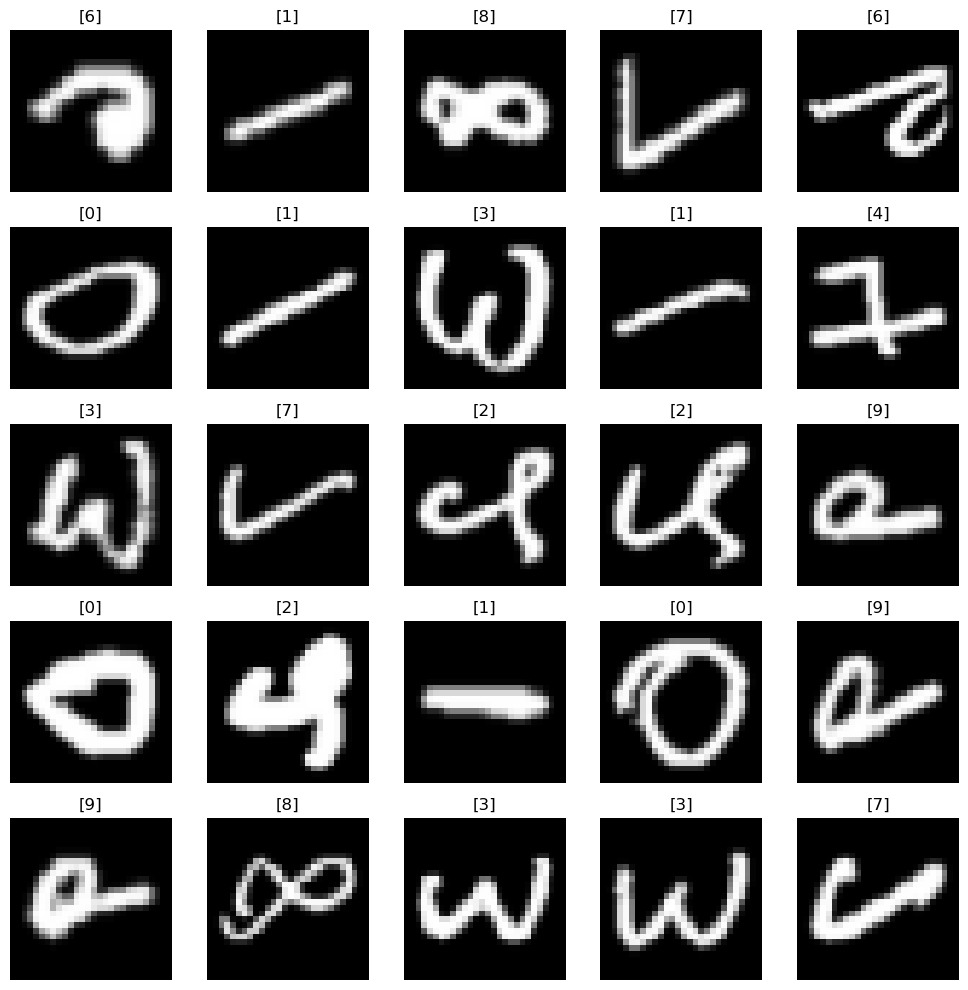

In [31]:
r, c = 5, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_train)-1)
        img = X_train[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y_train[ix])
plt.tight_layout()
plt.show()

In [32]:

def build_model(D_in=28*28, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [33]:
model = build_model()
test_input = torch.randn((64, 28*28)).cuda()
test_output = model(test_input)
test_output.shape

torch.Size([64, 10])

In [34]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 28*28)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

In [47]:
# fit de un batch
dataset = Dataset(X_train[:20000], y_train[:20000].squeeze())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

len(dataset)

20000

In [48]:
epochs = 100
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for e in range(1, epochs+1):
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (y_b == torch.argmax(y_pred, axis=1)).sum().item()
        if not e % 10:
            print(f"Epoch {e}/{epochs} loss {loss.item():.5f} acc {acc}/{y_b.shape[0]}")

Epoch 10/100 loss 0.00515 acc 64/64
Epoch 10/100 loss 0.00834 acc 64/64
Epoch 10/100 loss 0.07324 acc 63/64
Epoch 10/100 loss 0.02141 acc 64/64
Epoch 10/100 loss 0.02758 acc 63/64
Epoch 10/100 loss 0.18013 acc 62/64
Epoch 10/100 loss 0.12049 acc 59/64
Epoch 10/100 loss 0.07550 acc 62/64
Epoch 10/100 loss 0.00259 acc 64/64
Epoch 10/100 loss 0.00460 acc 64/64
Epoch 10/100 loss 0.01279 acc 64/64
Epoch 10/100 loss 0.01122 acc 64/64
Epoch 10/100 loss 0.02808 acc 64/64
Epoch 10/100 loss 0.01347 acc 64/64
Epoch 10/100 loss 0.08510 acc 63/64
Epoch 10/100 loss 0.03506 acc 63/64
Epoch 10/100 loss 0.01642 acc 63/64
Epoch 10/100 loss 0.12668 acc 63/64
Epoch 10/100 loss 0.05373 acc 63/64
Epoch 10/100 loss 0.01728 acc 64/64
Epoch 10/100 loss 0.04334 acc 63/64
Epoch 10/100 loss 0.00172 acc 64/64
Epoch 10/100 loss 0.00979 acc 64/64
Epoch 10/100 loss 0.06226 acc 63/64
Epoch 10/100 loss 0.01642 acc 64/64
Epoch 10/100 loss 0.06162 acc 63/64
Epoch 10/100 loss 0.05344 acc 62/64
Epoch 10/100 loss 0.02639 ac

In [53]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
accuracy

ValueError: Found input variables with inconsistent numbers of samples: [40000, 32]

In [43]:
dataset = {
    'train': Dataset(X_train, y_train.squeeze()),
    'val': Dataset(X_test, y_test.squeeze()),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(240000, 40000)

In [44]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def fit(model, dataloader, optimizer, scheduler=None, epochs=10, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [45]:
lr = 0.001
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)

Probando lr 0.01
Probando lr 0.001
Probando lr 0.0001


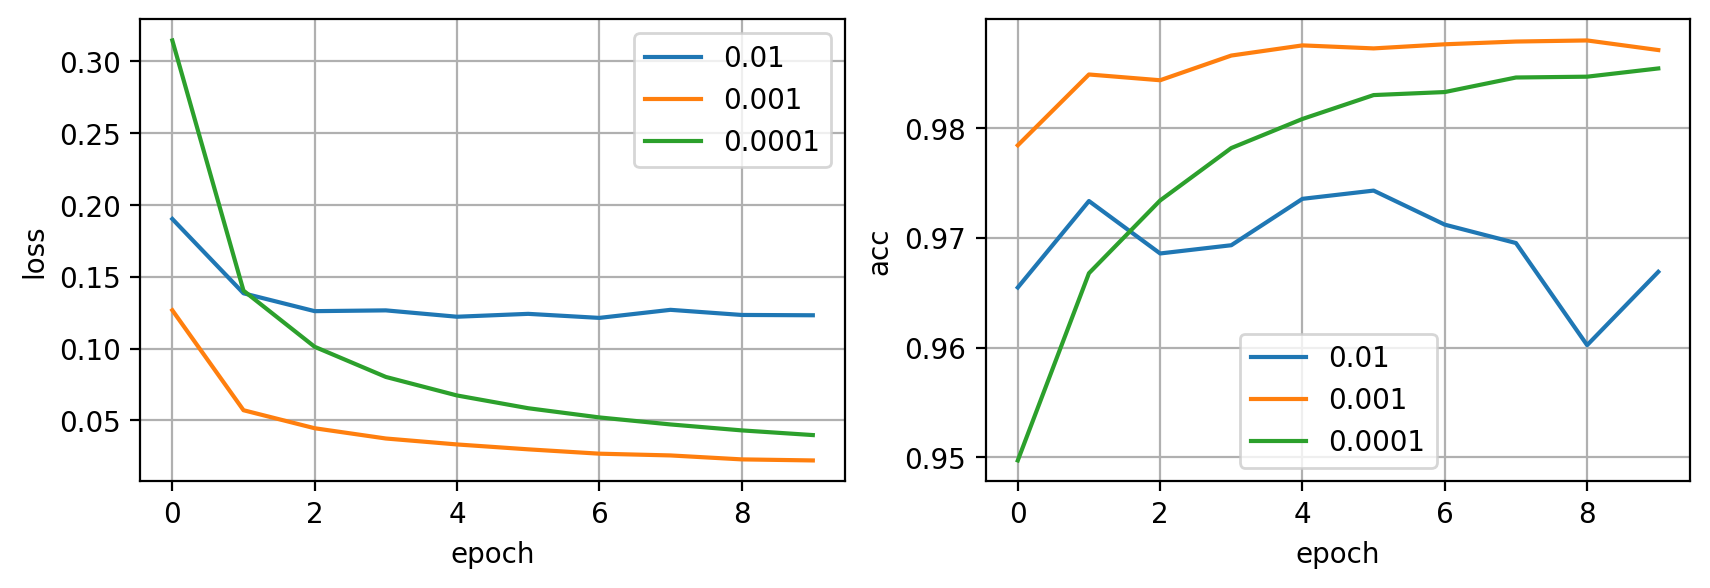

In [46]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()